In [1]:
import tensorflow as tf
import json
import os

from core.data  import load_records
from core.transformer import ASTROMER
from core.scheduler import CustomSchedule
from core.callbacks import get_callbacks
from core.losses import CustomMSE, ASTROMERLoss, CustomBCE
from core.metrics import CustomACC

import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [2]:
root_data = './experiments/macho_magn_time_normed'
conf_file = os.path.join(root_data, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'time_normed': True,
 'magn_normed': True,
 'data': './data/records/macho',
 'p': './experiments/macho_magn_time_normed',
 'batch_size': 512,
 'epochs': 1000,
 'layers': 2,
 'heads': 4,
 'head_dim': 512,
 'dff': 1024,
 'pe': 200,
 'dropout': 0.1,
 'lr': 0.001}

In [3]:
test_batches = load_records(os.path.join(conf['data'], 'test'), 
                                          conf['batch_size'], 
                                          magn_normed=conf['magn_normed'],
                                          time_normed=conf['time_normed'])

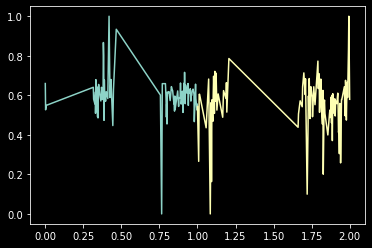

In [4]:
for x1, x2, t, y in test_batches:
    plt.plot(x1[0, :, 0], x1[0, :, 1])
    plt.plot(x2[0, :, 0]+1, x2[0, :, 1])
    break

In [5]:
learning_rate = 1e-3#CustomSchedule(opt.head_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)
# Model Instance
transformer = ASTROMER(num_layers=conf['layers'],
                    d_model=conf['head_dim'],
                    num_heads=conf['heads'],
                    dff=conf['dff'],
                    pe_input=conf['pe'],
                    rate=conf['dropout'])
# Compile
transformer.compile(optimizer=optimizer, 
                    loss=ASTROMERLoss(),
                    metrics=[CustomMSE(), CustomBCE(), CustomACC()])
# Create graph
transformer.model(conf['batch_size']).summary()

# Initialize graph
transformer.evaluate(test_batches.take(1))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Serie1 (InputLayer)             [(512, 202, 2)]      0                                            
__________________________________________________________________________________________________
Serie2 (InputLayer)             [(512, 202, 2)]      0                                            
__________________________________________________________________________________________________
TrueLength (InputLayer)         [(512,)]             0                                            
__________________________________________________________________________________________________
IsRandom (InputLayer)           [(512, 1)]           0                                            
______________________________________________________________________________________________

[10835.0595703125, 10834.166015625, 0.8936207294464111, 0.0]

In [6]:
expdir = '{}/train_model.h5'.format(conf['p'])
transformer.load_weights(expdir)
transformer.evaluate(test_batches)

2/2 [==============================] - 13s 74ms/step - loss: 3.5923 - RMSE: 3.6131 - BCE: 0.0067 - Accuracy: 1.0000


[3.5922691822052, 3.613126039505005, 0.006692918017506599, 1.0]

In [ ]:
rec_pred, rec_mask, cls_true, cls_pred, cls_true = transformer.predict(test_batches.take(1))

In [15]:
n = 2
for n in range(1):
    plt.figure(dpi=200)
    y_pred = rec_pred[n]
    y_true = rec_true[n]
    l_pred = cls_pred[n]
    l_true = cls_true[n]

    x_time = tf.range(100)
    
    plt.plot(x_time, y_pred[:100], color='darkred', label='Pred')
    plt.plot(x_time, y_true[:100], color='darkblue', linestyle='-', label='Real')
    
    plt.plot(x_time+100, y_pred[101:], color='darkred')
    plt.plot(x_time+100, y_true[101:], color='darkblue', marker='',linestyle='-')
    plt.title('true {:.0f} - pred {}'.format(l_true[0],l_pred.numpy()[0][0]))
    plt.legend()
    plt.show()

NameError: name 'rec_true' is not defined

<Figure size 1200x800 with 0 Axes>